In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

import sys,os,glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'src')
functionsdir = os.path.join(os.path.dirname(workdir),'plotting/src')
sys.path.insert(0,moduledir)
sys.path.insert(0,functionsdir)
for includedir in [moduledir,functionsdir]:
    print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                     for x in glob.glob(os.path.join(includedir,'*.py'))])

from conditionalstats import *
from plot2D import *
# from plot1DInvLog import *
from plot1D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['conditionalstats']
Own modules available: ['plot2D', 'plot1D', 'plotCondPDFs', 'plot1DInvLog']


# Linear distributions

In [3]:
N = int(1e7)
x_norm = np.random.normal(size=N) # Sampling a standard normal distribution
xmax = 4
xmin = -xmax

In [4]:
y_norm_from_x = x_norm + np.random.normal(size=N,scale=0.1) # add noise with 10% standard deviation

In [5]:
dist_x_linear = Distribution(name='x',nbins=40)
dist_x_linear.computeDistribution(sample=x_norm,vmin=xmin,vmax=xmax)

In [6]:
dist_y_linear = Distribution(name='y',nbins=40)
dist_y_linear.computeDistribution(sample=y_norm_from_x,vmin=xmin,vmax=xmax)

In [7]:
# Joint distribution
jd_xy_linear = JointDistribution(name='xy',distribution1=dist_x_linear,distribution2=dist_y_linear)
jd_xy_linear.computeDistribution(x_norm,y_norm_from_x)

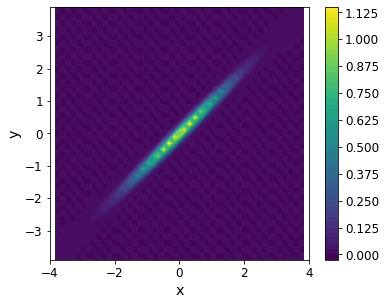

In [8]:
fig,ax = plt.subplots(figsize=(6,4.5))

x = dist_x_linear.percentiles
y = dist_y_linear.percentiles
Z = jd_xy_linear.density
h = subplotSmooth2D(ax,x,y,Z,fplot='contourf',xmin=xmin,xmax=xmax,nx=50,nlev=50,vmin=None,vmax=None)

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(h)

# Extremes of lognormal distribution

First create a reference lognormal distribution

In [9]:
y1_lognorm = np.exp(x_norm) # lognormal distribution from x
ymin,ymax = np.exp(xmin),np.exp(xmax)
print(ymin,ymax)

0.01831563888873418 54.598150033144236


In [10]:
dist_y1_IL = Distribution(name='y1',bintype='invlogQ',nd=4,fill_last_decade=True)
dist_y1_IL.computeDistribution(sample=y1_lognorm,vmin=ymin,vmax=ymax)

Then add noise to this lognormal to compare the tails

In [11]:
y2_lognorm = y1_lognorm *(1 + np.random.normal(size=N,scale=0.5))

In [12]:
dist_y2_IL = Distribution(name='y2',bintype='invlogQ',nd=4,fill_last_decade=True)
dist_y2_IL.computeDistribution(sample=y2_lognorm,vmin=ymin,vmax=ymax)

Compare the distributions

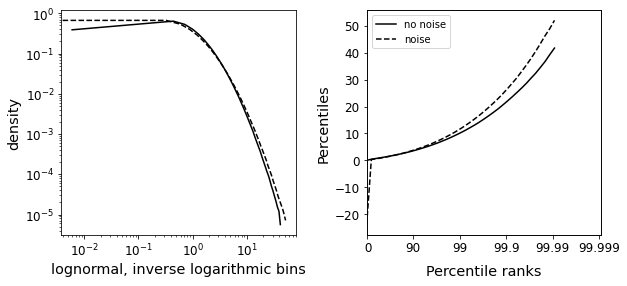

In [28]:
# plt.rcParams.update({'axes.labelpad':4})

fig,axs = plt.subplots(ncols=2,figsize=(10,4))


# distribution on log-log
ax = axs[0]
ax.plot(dist_y1_IL.percentiles,dist_y1_IL.density,'k',label='no noise')
ax.plot(dist_y2_IL.percentiles,dist_y2_IL.density,'k--',label='w/ noise')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('lognormal, inverse logarithmic bins')
ax.set_ylabel('density')

# distribution on inverse logarithmic ranks
ax = axs[1]
_,h1 = subplotRanksILog(ax,dist_y1_IL.ranks,dist_y1_IL.percentiles,col='k',ltype='-',labels='no noise')
_,h2 = subplotRanksILog(ax,dist_y2_IL.ranks,dist_y2_IL.percentiles,col='k',ltype='--',labels='noise',setframe=False)

ax.set_xlabel('lognormal, inverse logarithmic bins')
ax.set_ylabel('density')

ax.set_xlabel('Percentile ranks',labelpad=30)
ax.set_ylabel('Percentiles')

plt.legend(loc='upper left',handles=h1+h2)
plt.show()

In [15]:
??subplotRanksILog

Make joint distributions

In [31]:
# Joint distribution
jd_y1y2_IL = JointDistribution(name='xy',distribution1=dist_y1_IL,distribution2=dist_y2_IL)
jd_y1y2_IL.computeDistribution(x_norm,y_norm_from_x)

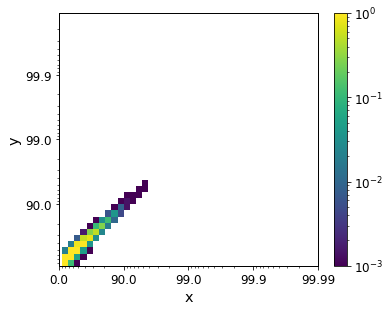

In [32]:
# Show joint distribution

fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()

##-- create inverse-log frame
# define axes values
x = np.flipud(1./(1-dist_y1_IL.ranks/100.))
y = np.flipud(1./(1-dist_y2_IL.ranks/100.))
Nx = len(x)
Ny = len(y)
# h = subplotSmooth2D(ax,x,y,Z,fplot='contourf',xmin=ymin,xmax=ymin,nx=50,nlev=50,vmin=None,vmax=None)
h = ax.matshow(np.full((Nx,Ny),np.nan),norm=LogNorm(vmin=1e-3, vmax=1),origin='lower',extent=[x[0],x[-1],y[0],y[-1]])
ax.set_xscale('log')
ax.set_yscale('log')
# axes labels and positions
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('x')
ax.set_ylabel('y')

# set xticks
xtick_pos = np.mod(np.log10(np.round(x,5)),1) == 0
xticks = x[xtick_pos]
xticklabels = np.array(dist_y1_IL.ranks[xtick_pos],dtype=str)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# set yticks
ytick_pos = np.mod(np.log10(np.round(y,5)),1) == 0
yticks = y[ytick_pos]
yticklabels = np.array(dist_y2_IL.ranks[ytick_pos],dtype=str)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)


##-- show values
# values
Z = jd_y1y2_IL.density.T
h = ax_show.matshow(Z,norm=LogNorm(vmin=1e-3, vmax=1),origin='lower')

ax_show.set_xticks([])
ax_show.set_yticks([])


plt.colorbar(h)

plt.show()

In [33]:
#### Convert to plotting method -- > stored in plot2D.py
    
def setFrame(ax,xranks,yranks):
    """Set inverse-logarithmic axes on x and y axes"""
    
    ##-- create inverse-log frame
    # define axes values
    x = np.flipud(1./(1-xranks/100.))
    y = np.flipud(1./(1-yranks/100.))
    Nx = len(x)
    Ny = len(y)
    # h = subplotSmooth2D(ax,x,y,Z,fplot='contourf',xmin=ymin,xmax=ymin,nx=50,nlev=50,vmin=None,vmax=None)
    ax.matshow(np.full((Nx,Ny),np.nan),origin='lower',extent=[x[0],x[-1],y[0],y[-1]])
    ax.set_xscale('log')
    ax.set_yscale('log')
    # axes labels and positions
    ax.xaxis.set_ticks_position('bottom')

    # set xticks
    xtick_pos = np.mod(np.log10(np.round(x,5)),1) == 0
    xticks = x[xtick_pos]
    xticklabels = np.array(xranks[xtick_pos],dtype=str)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    # set yticks
    ytick_pos = np.mod(np.log10(np.round(y,5)),1) == 0
    yticks = y[ytick_pos]
    yticklabels = np.array(yranks[ytick_pos],dtype=str)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    return ax


def showData(ax,values,scale='lin',vmin=1e-3,vmax=1,cmap=None):
    """Show matrix data as it is, regardless of preset frame and ticks"""

    if scale == 'lin':
        h = ax.matshow(values,vmin=vmin,vmax=vmax,origin='lower',cmap=cmap)
    elif scale == 'log':
        h = ax.matshow(values,norm=LogNorm(vmin=vmin,vmax=vmax),origin='lower',cmap=cmap)

    ax.set_xticks([])
    ax.set_yticks([])

    return h


(41, 41)
(41, 41)
(41, 41)


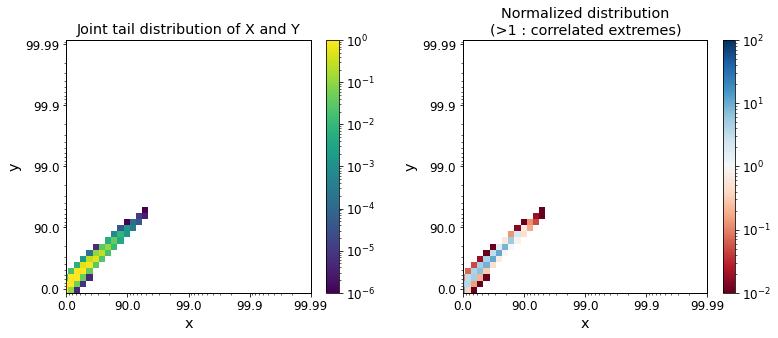

In [34]:
# Show joint distribution and normalized joint distribution side to side

fig,axs = plt.subplots(ncols=2,figsize=(13,4.5))

#-- Joint distribution
ax = axs[0]
ax_show = ax.twinx().twiny()

# create inverse-log frame
setFrame(ax,dist_y1_IL.ranks,dist_y2_IL.ranks)

# show values
Z = jd_y1y2_IL.density.T
h = showData(ax_show,Z,scale='log',vmin=1e-6,vmax=1)

#- colorbar
plt.colorbar(h)

#- labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Joint tail distribution of X and Y')


#-- Normalized Joint distribution
ax = axs[1]
ax_show = ax.twinx().twiny()


# create inverse-log frame
setFrame(ax,dist_y1_IL.ranks,dist_y2_IL.ranks)

#- show values
f_x,f_y = np.meshgrid(dist_y1_IL.density,dist_y2_IL.density)
norm_factor = f_x*f_y
print(np.array(norm_factor).shape)
print(jd_y1y2_IL.density.T.shape)
Z_norm = jd_y1y2_IL.density.T / norm_factor
print(Z_norm.shape)
h = showData(ax_show,Z_norm,scale='log',vmin=0.01,vmax=100,cmap=plt.cm.RdBu)

#- colorbar
plt.colorbar(h)

#- labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Normalized distribution\n(>1 : correlated extremes)')

plt.show()